### Stock Market Prediction And Forecasting Using Stacked LSTM

In [1]:
### Data Collection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [4]:
df = yf.download("AAPL", start="2015-05-01", end="2025-06-01")

C:\Users\acer\AppData\Local\Temp\ipykernel_41968\3128206942.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download("AAPL", start="2015-05-01", end="2025-06-01")
[*********************100%***********************]  1 of 1 completed


In [5]:
df.to_csv('AAPL.csv')

In [6]:
df=pd.read_csv('AAPL.csv')

In [7]:
df.head()

,Price,Close,High,Low,Open,Volume
0,Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
1,Date,NaN,NaN,NaN,NaN,NaN
2,2015-05-01,28.699962615966797,28.962592971997786,27.88759587803151,28.065648140599507,234050400
3,2015-05-04,28.644319534301758,29.06052136811745,28.546389691051004,28.822373486021608,203953200
4,2015-05-05,27.998878479003906,28.588678600449384,27.994426196173162,28.521907942375222,197085600


In [8]:
df.tail()

,Price,Close,High,Low,Open,Volume
2533,2025-05-23,194.8597412109375,197.28462846236872,193.05354646446796,193.2630967266574,78432900
2534,2025-05-27,199.78936767578125,200.31825293342968,197.01519441683536,197.88337691051132,56288500
2535,2025-05-28,199.99893188476562,202.3040763244224,199.48002009942556,200.16857290124128,45339700
2536,2025-05-29,199.5299072265625,203.38179807643976,198.09293019267844,203.15228556391767,51396800
2537,2025-05-30,200.4280242919922,201.53569281345096,196.36656797106642,198.95112277889336,70819900


In [9]:
# Drop first two rows
df = df.iloc[2:]

# Reset index to start from 0
df = df.reset_index(drop=True)

df = df.rename(columns={'Price': "Date"})

In [10]:
df.head()

,Date,Close,High,Low,Open,Volume
0,2015-05-01,28.699962615966797,28.962592971997786,27.88759587803151,28.065648140599507,234050400
1,2015-05-04,28.644319534301758,29.06052136811745,28.546389691051004,28.822373486021608,203953200
2,2015-05-05,27.998878479003906,28.588678600449384,27.994426196173162,28.521907942375222,197085600
3,2015-05-06,27.82304573059082,28.21031106382418,27.455810572398878,28.168022874672648,288564000
4,2015-05-07,27.995141983032227,28.178408847882512,27.718005393148463,27.885627588016693,175763600


In [11]:
df1=df.loc[:, 'Close'].copy()

In [12]:
df1

0       28.699962615966797
1       28.644319534301758
2       27.998878479003906
3        27.82304573059082
4       27.995141983032227
               ...        
2531     194.8597412109375
2532    199.78936767578125
2533    199.99893188476562
2534     199.5299072265625
2535     200.4280242919922
Name: Close, Length: 2536, dtype: object

In [13]:
df1 = df1.apply(pd.to_numeric, errors='coerce')

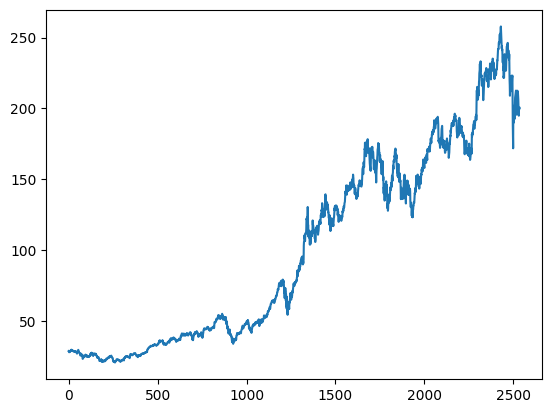

In [14]:
df1.plot()
plt.show()

In [ ]:
### LSTM are sensitive to the scale of the data. so we apply MinMax scaler 

In [33]:
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [34]:
print(df1)

[[0.03412388]
 [0.03388936]
 [0.03116888]
 ...
 [0.75614371]
 [0.75416678]
 [0.75795232]]


In [35]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:1]

In [36]:
training_size,test_size

(1648, 888)

In [37]:
train_data

array([[0.03412388],
       [0.03388936],
       [0.03116888],
       ...,
       [0.5238223 ],
       [0.52361585],
       [0.53236801]], shape=(1648, 1))

In [38]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

In [39]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [40]:
print(X_train.shape), print(y_train.shape)

(1547, 100)
(1547,)


(None, None)

In [41]:
print(X_test.shape), print(ytest.shape)

(787, 100)
(787,)


(None, None)

In [42]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [43]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [44]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')


c:\Users\acer\anaconda3\envs\DL\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [45]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 50)        │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,851 (198.64 KB)

 Trainable params: 50,851 (198.64 KB)

 Non-trainable params: 0 (0.00 B)

In [46]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0095 - val_loss: 0.0077
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 5.4821e-04 - val_loss: 0.0053
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 2.7373e-04 - val_loss: 0.0041
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 2.5397e-04 - val_loss: 0.0045
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 2.4205e-04 - val_loss: 0.0052
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 2.3789e-04 - val_loss: 0.0044
Epoch 7/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 110ms/step - loss: 2.3181e-04 - val_loss: 0.0048
Epoch 8/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 2.4397e-04 - val_loss: 0.0031
Epoch 9/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 96ms/step - loss: 2.3549e-04 - val_loss: 0.0032
Epoch 10/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 2.2075e-04 - val_loss: 0.0055
Epoch 11/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 2.1813e-04 - val_loss: 0.0050
Epoch 12/1

In [47]:
import tensorflow as tf

In [48]:
tf.__version__

'2.20.0'

In [49]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [50]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [51]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

71.33815727967632

In [52]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

181.16289530304118

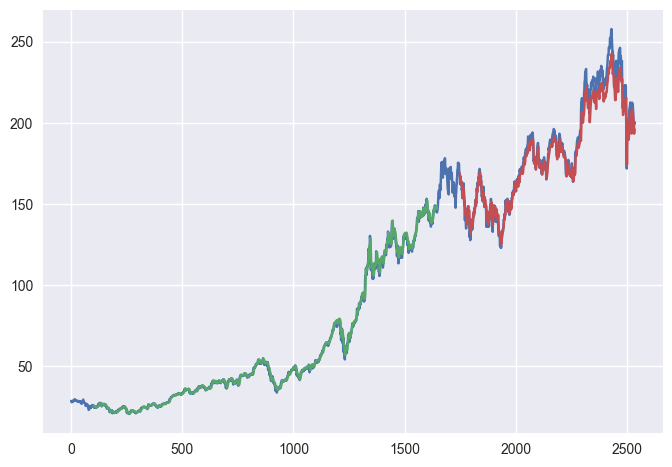

In [53]:
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [54]:
len(test_data)

888

In [72]:
x_input=test_data[788:].reshape(1,-1)
x_input.shape

(1, 100)

In [74]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [75]:
temp_input

[0.9411723851467275,
 0.9294655820627662,
 0.9315215498808593,
 0.9069750293601444,
 0.896694740062441,
 0.891995219667406,
 0.9112548922955159,
 0.8709314380123203,
 0.8781485172734186,
 0.8473499688605322,
 0.8523431530043523,
 0.8516298961112233,
 0.8479374249887415,
 0.877644992637142,
 0.9128913955999045,
 0.9175069845030068,
 0.9100799800390975,
 0.9034084233179016,
 0.8698824551514605,
 0.8899812497529388,
 0.8885966052396678,
 0.8917436181375665,
 0.8682879497506983,
 0.8694220860945608,
 0.8902990960618516,
 0.908151678130189,
 0.9277264958237932,
 0.9406224248497801,
 0.940076323472002,
 0.9417564968783234,
 0.9457890674102611,
 0.9446129331627724,
 0.9511238945312048,
 0.950871842794129,
 0.9228118406850687,
 0.9099579738780276,
 0.9290286880974798,
 0.9130243996806069,
 0.9042031034055035,
 0.9034050146059689,
 0.901682778980702,
 0.9173930820721923,
 0.8687079931022785,
 0.8408159826077227,
 0.8246017046727193,
 0.7939372537009668,
 0.8099415421178396,
 0.8120839497253259,

In [76]:
# demonstrate prediction for next 10 days
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1

        
print(lst_output)

[0.74267566]
101
1 day input [0.92946558 0.93152155 0.90697503 0.89669474 0.89199522 0.91125489
 0.87093144 0.87814852 0.84734997 0.85234315 0.8516299  0.84793742
 0.87764499 0.9128914  0.91750698 0.91007998 0.90340842 0.86988246
 0.88998125 0.88859661 0.89174362 0.86828795 0.86942209 0.8902991
 0.90815168 0.9277265  0.94062242 0.94007632 0.9417565  0.94578907
 0.94461293 0.95112389 0.95087184 0.92281184 0.90995797 0.92902869
 0.9130244  0.9042031  0.90340501 0.90168278 0.91739308 0.86870799
 0.84081598 0.8246017  0.79393725 0.80994154 0.81208395 0.80658113
 0.81729265 0.81250393 0.83002046 0.84035401 0.85303982 0.84371442
 0.85345986 0.82846615 0.84623481 0.85068742 0.85362785 0.76667534
 0.70446442 0.67539621 0.63742277 0.74844471 0.71303353 0.74550428
 0.7638609  0.76226472 0.72920594 0.74058956 0.72454321 0.7521833
 0.7725982  0.78843443 0.79225695 0.79586961 0.80036422 0.80578298
 0.80922751 0.77574869 0.74861277 0.74701653 0.73752314 0.7427319
 0.74710052 0.79976101 0.80876213 0.

In [77]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [79]:
len(df1)

2536

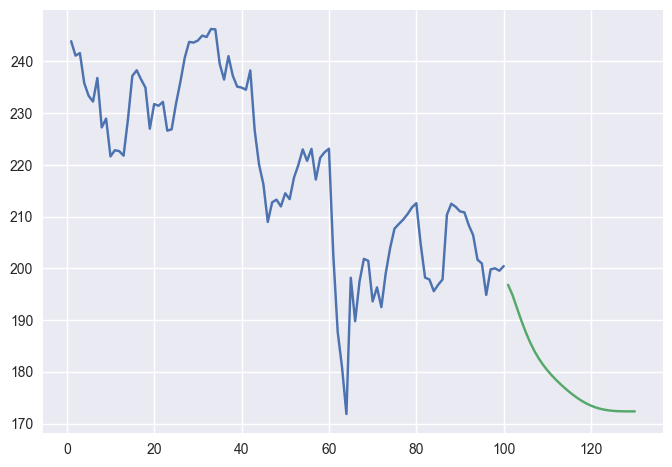

In [81]:
plt.plot(day_new,scaler.inverse_transform(df1[2436:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

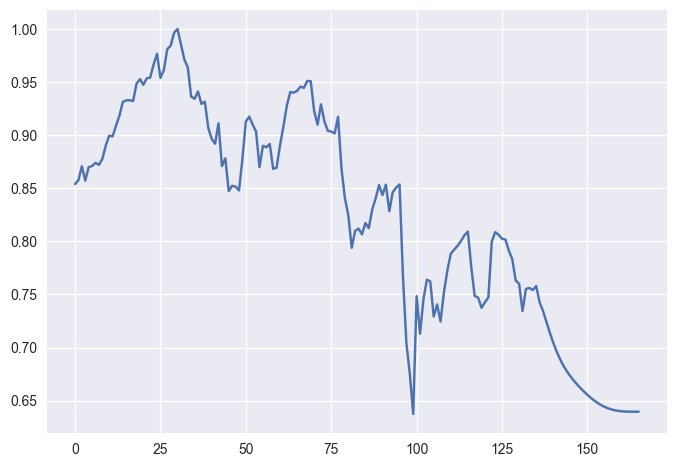

In [88]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[2400:])

In [89]:
df3=scaler.inverse_transform(df3).tolist()

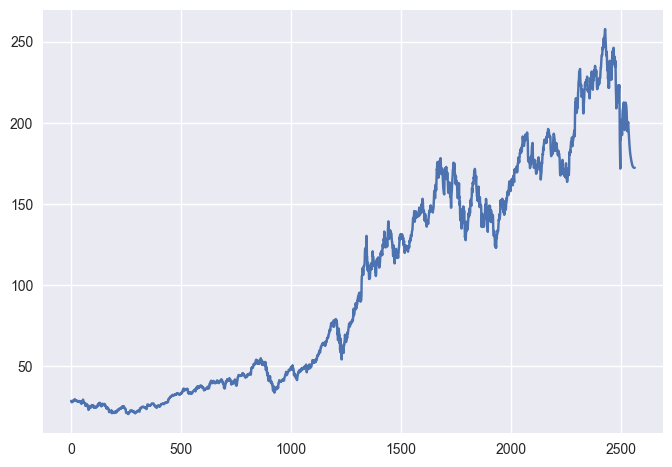

In [90]:
plt.plot(df3)